# Load Libraries

In [ ]:
!pip install cdlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 80.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.5 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=bf08dddfeaddf27e84b1f076211876a53b616b4baa84edaad82a2bd18785679a
  Stored in directory: /root/.cache/pip/wheels/49/27/15/dcf90953e3e3322e6f3e447514b20cf39b53c6518cb4a7bace
Successfully built python-igraph


In [ ]:
!pip install --upgrade scipy networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [ ]:
import networkx as nx
import json
import matplotlib.pyplot as plt
import copy
import time
import pandas as pd
import numpy as np
import scipy.sparse as sp


# Load Data

In [ ]:
data={}
with open("movie_reduced.json","r",encoding="utf-8") as f:
    data=json.load(f)

In [ ]:
data.__len__()

100

# Create Graph

In [ ]:
G = nx.karate_club_graph()

In [ ]:
G=nx.Graph()
G.add_edges_from([(1,2),(1,3),(2,3),(1,4),(2,4),(2,5),(3,5),(4,5),(3,6),(6,7),(6,8),(7,8),(3,10),(6,10),(5,9),(9,10),(9,11),(9,12),(10,12),(11,12)])
labels=[1,1,1,2,2,4,4,4,3,3,3,3]

In [ ]:
G = nx.Graph()
count=0
limit=100+1

for i in data:
  count+=1
  if count==limit:
    break
  lengthOfCast=len(data[i]['CastId'])
  for j in range(0,lengthOfCast-1):
    val1=data[i]['CastId'][j]
    for k in range(j+1,lengthOfCast):
      val2=data[i]['CastId'][k]
      G.add_edge(int(val1),int(val2))

In [ ]:
G.nodes().__len__()

4322

In [ ]:
G.edges().__len__()

130612

In [ ]:
nx.average_clustering(G)

0.9754147043450085

In [ ]:
plt.figure(figsize=(20,20))
nx.draw(G,with_labels=False,width=0.5)
plt.show()

# Finding Optimum K

## Silhoutte, Elbow, Modularity

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

cost=[]
silhouettes = []

L = laplacian(G)

lower_k=12
upper_k=G.nodes().__len__()-1
upper_k=226

for i in range(lower_k, upper_k):
    _, eig_vectors = sp.linalg.eigs(L, i)
    X = eig_vectors.real
    X = np.apply_along_axis(normalize_eigenvectors, 0, X)

    kmeans = KMeans(n_clusters=i, n_init="auto",verbose=False).fit(X)

    silhouettes.append(silhouette_score(X, labels, metric = 'euclidean'))
    cost.append(kmeans.inertia_)


### Elbow

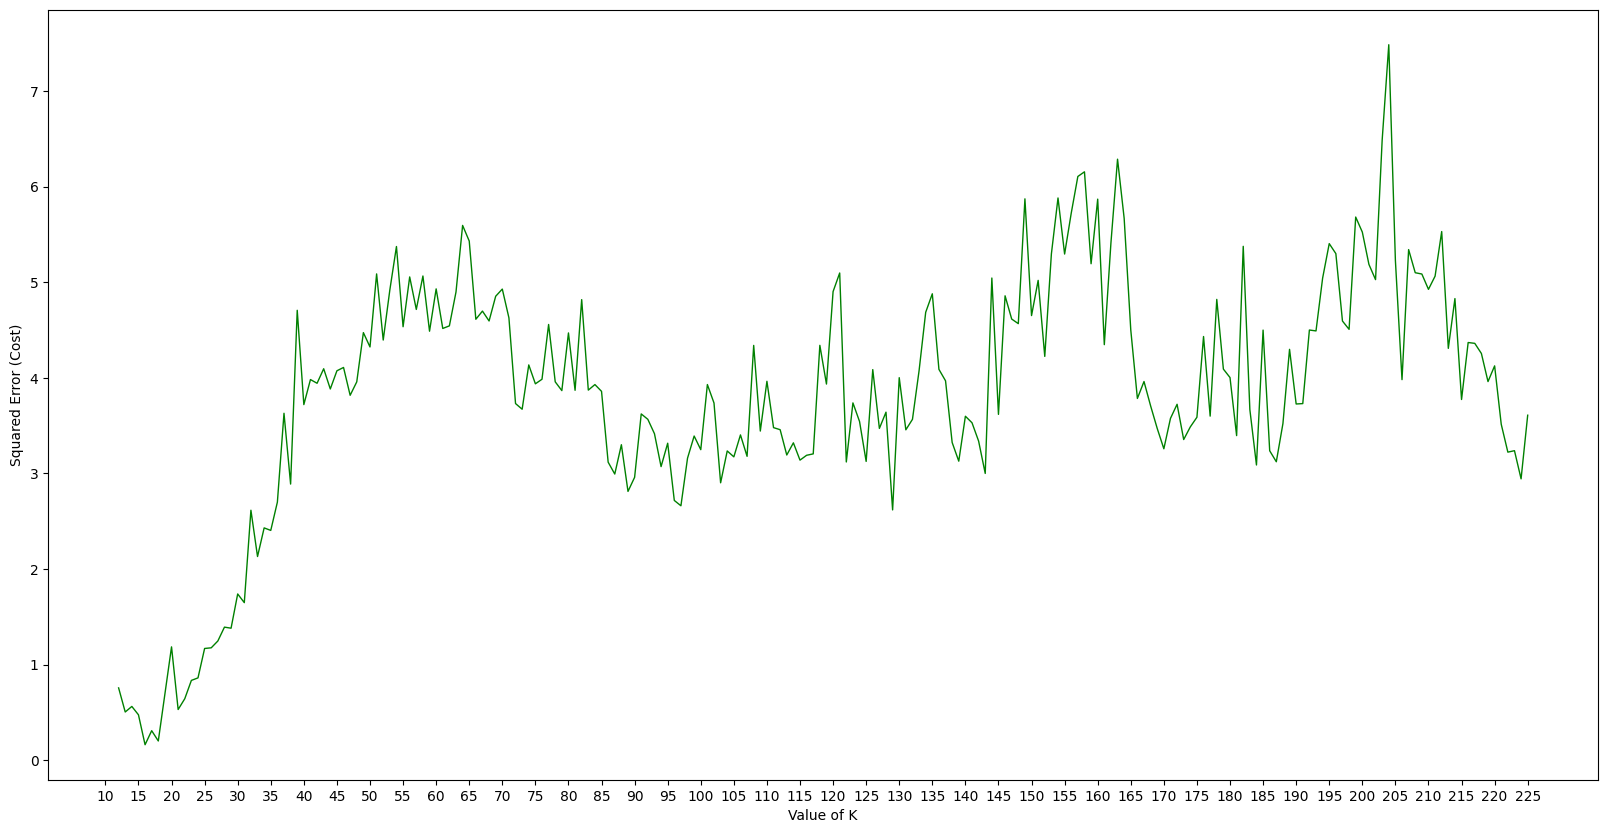

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.xticks(range(lower_k-2, upper_k,5))
plt.plot(range(lower_k, upper_k), cost, color ='g', linewidth ='1')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show()

### Silhouettes

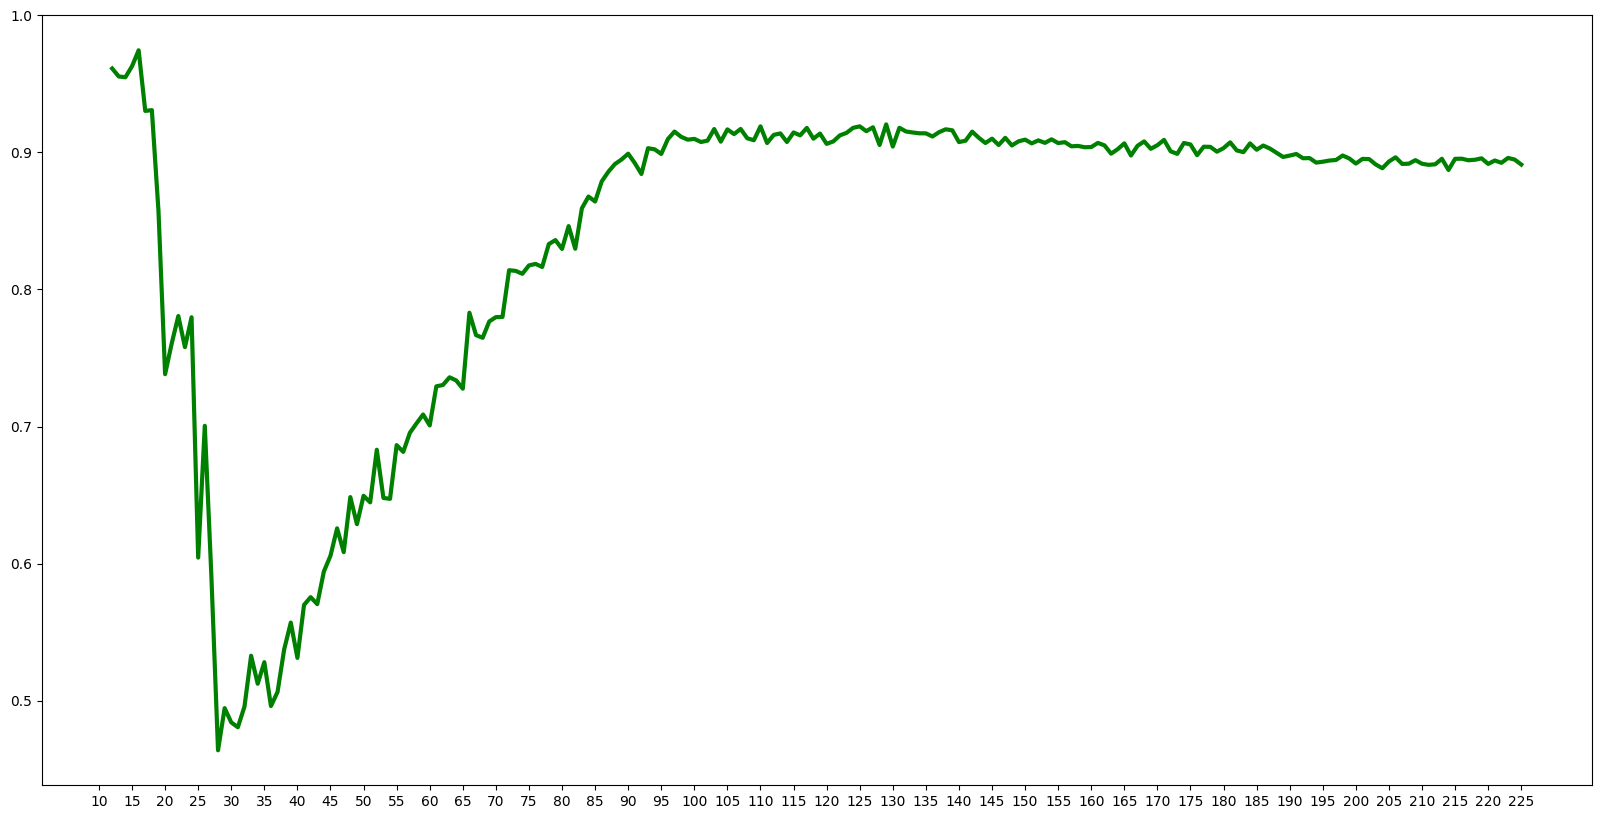

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(range(lower_k-2, upper_k,5))
plt.plot(range(lower_k, upper_k),silhouettes, color ='g', linewidth ='3')
plt.show()

In [ ]:
max_val=0
max_count=0
count=lower_k
for i in silhouettes:
  if i>max_val:
    max_val=i
    max_count=count
  count+=1

In [ ]:
max_count,max_val

(16, 0.9744743483689936)

In [ ]:
from sklearn.cluster import KMeans

L = laplacian(G)


_, eig_vectors = sp.linalg.eigs(L, 16)
X = eig_vectors.real
X = np.apply_along_axis(normalize_eigenvectors, 0, X)

kmeans = KMeans(n_clusters=16, random_state=0, n_init="auto").fit(X)

labels = kmeans.labels_


In [ ]:
plt.figure(figsize=(100,100))
nx.draw(G,node_color=labels,with_labels=False,width=0.5)
plt.show()

### Save cost,silhoutte scores

In [ ]:
import json

json_object = json.dumps(cost, indent = 4,ensure_ascii=False)
with open ("cost_100.json","a",encoding='utf-8') as f:
    f.write(json_object)

In [ ]:
import json

json_object = json.dumps(silhouettes, indent = 4,ensure_ascii=False)
with open ("silhouettes_100.json","a",encoding='utf-8') as f:
    f.write(json_object)

### Modularity

In [ ]:
Q_dict={}

In [ ]:
from sklearn.cluster import KMeans

ct=10
countdown=ct
count=1
length_G=len(G.nodes)
L = laplacian(G)

while True:
  _, eig_vectors = sp.linalg.eigs(L, length_G-count)
  X = eig_vectors.real
  X = np.apply_along_axis(normalize_eigenvectors, 0, X)

  kmeans = KMeans(n_clusters=length_G-count, random_state=0, n_init="auto").fit(X)

  labels = kmeans.labels_

  comm=find_communities1(G,labels)
  Q=modularity(G,comm,length_G-count)

  if (count!=1 and Q_dict[list(Q_dict.keys())[-1]]>Q):
      countdown-=1
  else:
    countdown=ct

  Q_dict[length_G-count]=Q
  if length_G-count<500:
    count+=1
  else:
    count*=2
  if count>=length_G or countdown==0:
    break

In [ ]:
Q_dict

{4321: -0.001144523593570765,
 4320: -0.0011364849028788408,
 4318: -0.0011143120302286923,
 4314: -0.0010884794946360728,
 4306: -0.0010370928607742653,
 4290: -0.0005466378840210037,
 4258: -0.0005160615970944117,
 4194: 0.0022152067813340556,
 4066: 0.08476955142311698,
 3810: 0.17252764918730745,
 3298: 0.31450289574300416,
 2274: 0.5495995407025434,
 226: 0.9000865886381448,
 225: 0.901481063951505,
 224: 0.9026242203298904,
 223: 0.9020616934639708,
 222: 0.9030271091717762,
 221: 0.9024230160098471,
 220: 0.9005181129122678,
 219: 0.9015183393818152,
 218: 0.9030127949141432,
 217: 0.9032060959519604,
 216: 0.9027892282668329,
 215: 0.9028326662478403,
 214: 0.9032586247064137,
 213: 0.9021297300635902,
 212: 0.9030573520373354,
 211: 0.9032316398506306,
 210: 0.9030421906268181,
 209: 0.9026540366880875,
 208: 0.9015949070665503,
 207: 0.9027031903132339,
 206: 0.9033485807127912,
 205: 0.8994444022022132,
 204: 0.9031472154266661,
 203: 0.9012024857094735,
 202: 0.902770308831

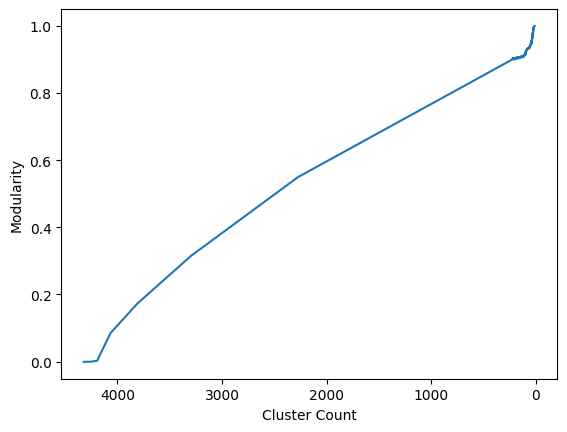

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


ax=sns.lineplot(data=Q_dict,)
ax.set(xlabel='Cluster Count',ylabel='Modularity')
ax.axes.invert_xaxis()
plt.show()

In [ ]:
old_val=Q_dict[4321]
for cluster_count in Q_dict:
  if Q_dict[cluster_count]>=old_val:
    old_val=Q_dict[cluster_count]
  else:
    print(Q_dict[cluster_count])
    break
old_val

0.9020616934639708


0.9026242203298904

226.   0.9000865886381448
225.   0.901481063951505
224.   0.9026242203298904
223.   0.9020616934639708
222.   0.9030271091717762
221.   0.9024230160098471







Save modularity scores

In [ ]:
import json

json_object = json.dumps(Q_dict, indent = 4,ensure_ascii=False)
with open ("Q.json_100","a",encoding='utf-8') as f:
    f.write(json_object)

# Finding Clusters for Known K


## Calculate laplacian, eigenvectors

In [ ]:
# Calculate Laplacian
L = laplacian(G)

In [ ]:
k=16

In [ ]:
# Get eigenvectors from the Laplacian
_, eig_vectors = sp.linalg.eigs(L, k)
# _, eig_vectors = np.linalg.eig(L)


# Use eigenvectors as features
X = eig_vectors.real

In [ ]:
X = np.apply_along_axis(normalize_eigenvectors, 0, X)

## Finding the Community

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k, n_init="auto",verbose=False).fit(X)
labels = kmeans.labels_


In [ ]:
plt.figure(figsize=(20,20))
nx.draw(self.G,node_color=self.labels,with_labels=False,width=0.5)
plt.show()

# Functions

In [ ]:
def laplacian(G):

    I = np.ones(D.shape)
    D_inv_root = np.linalg.inv(np.sqrt(D))

    L = I - np.dot(D_inv_root, W).dot(D_inv_root)


    return L

In [ ]:
def normalize_eigenvectors(e):
    """
    Normalizes an eigenvector
    """
    return e/np.sqrt(np.sum(e**2))

## My functions

In [ ]:
def find_communities(G):
    communities = {}
    temp_count=0
    n=len(G.nodes())
    for idx1,node1 in enumerate(G.nodes()):
        if n==len(communities):
            break
        count=temp_count+1
        for idx2,node2 in enumerate(G.nodes()):
            if node2 in communities:
                continue
            elif idx2==idx1:
                communities.update({node1:count})
            elif idx2<idx1:
                continue
            else:
                if (node1,node2) in G.edges():
                    communities.update({node2:count})
                    temp_count=count
    return communities,count

def find_communities1(G,labels):
    communities = {}
    count=0
    for node in G.nodes():
        communities[node] = labels[count]
        count+=1
    return communities

def group_communities(communities):
    count=0
    node_cmap=[]
    values={}
    for i in communities:
        temp=communities[i]
        if temp in values:
            node_cmap.append(values[temp])
        else:
            values.update({temp:count})
            node_cmap.append(values[temp])
            count+=1
            if count==1:
              count+=1
    print(count)
    return node_cmap

def group_communities2(communities):
    communities_dict = {}
    count=0
    for comunity in communities:
      count+=1
      for node in comunity:
        communities_dict.update({node:count})
    node_cmap=group_communities(communities_dict)
    print(count)
    return node_cmap

### Modularity

In [ ]:
def calculate_modularity(M,n):
  Q=0
  for i in range(n):
        a=0
        for j in range(n):
            if i==j:
                e=M[i][j]
            else:
                a+=M[i][j]
        Q+=(e-(a*a))
  return Q

In [ ]:
def modularity(G,communities,n):
  total_edge=G.edges.__len__()
  C=[[0]*n for i in range(n)]
  for edge in G.edges():
      c1=communities[edge[0]]
      c2=communities[edge[1]]
      if c2==c1:
          C[c1-1][c2-1]+=1
      else:
          C[c1-1][c2-1]+=1
          C[c2-1][c1-1]+=1

  M=copy.deepcopy(C)
  for i in range(n):
      for j in range(n):
          M[i][j]=M[i][j]/total_edge

  Q=calculate_modularity(M,n)
  return Q

In [ ]:
def modularity_based(G,communities,n):
  total_edge=G.edges.__len__()
  C=[[0]*n for i in range(n)]
  for edge in G.edges():
      c1=communities[edge[0]]
      c2=communities[edge[1]]
      if c2==c1:
          C[c1-1][c2-1]+=1
      else:
          C[c1-1][c2-1]+=1
          C[c2-1][c1-1]+=1

  M=copy.deepcopy(C)
  for i in range(n):
      for j in range(n):
          M[i][j]=M[i][j]/total_edge

  Q=calculate_modularity(M,n)

  old_n=n
  while True:
      n=n-1
      if n==0:
        n=n+1
        break
      Q_old=Q
      new_C=[[0]*(n) for i in range(n)]
      for i in range(n):
          for j in range(n):
              new_C[i][j]=C[i+1][j+1]
              if (i,j)==(0,0):
                  new_C[i][j]+=C[i][j]
                  new_C[i][j]+=C[i][j+1]
              elif i==0:
                  new_C[i][j]+=C[i][j+1]
              elif j==0:
                  new_C[i][j]+=C[i+1][j]

      old_communities=copy.deepcopy(communities)
      for i in communities:
          if communities[i]==1:
              continue
          else:
              communities[i]-=1

      old_C=copy.deepcopy(C)
      C=copy.deepcopy(new_C)
      M=copy.deepcopy(C)
      for i in range(n):
          for j in range(n):
              M[i][j]=M[i][j]/total_edge

      Q=calculate_modularity(M,n)

      if Q_old>=Q:
          C=copy.deepcopy(old_C)
          communities=copy.deepcopy(old_communities)
          n=n+1
          break
  return communities,n

## Temp

In [ ]:
# Q_dict={}
# # Q_dict[1]=Q
# count=1
# length_G=len(G.nodes)
# while True:
#   # Cluster nodes using spectral clustering
#   spectral = SpectralClustering(n_clusters=n-count, affinity='rbf',assign_labels='kmeans', random_state=0).fit(X)
#   # labels = spectral.fit_predict(X)
#   labels = spectral.labels_

#   comm=find_communities1(G,labels)
#   Q=modularity(G,comm,n-count)
#   Q_dict[length_G-count]=Q
#   count+=1
#   if count==length_G:
#     break